# Final Project
Jack Dean  
Math 469 - Financial Stochastic Analysis  
Lehigh University

In [1]:
'''
Packages used
'''
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

## Generate US Treasury Term Structure

In [2]:
'''
Pull rates data
---
Rates data saved in an excel spreadsheet
Aggregated with market data from wsj
https://www.wsj.com/market-data/bonds/treasuries
'''
t_bonds_df = pd.read_excel('Table.xlsx')
t_bonds_df['px_last'] = [i if i>=25 else 100 - i for i in t_bonds_df['ask'].to_list()]
t_bonds_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in t_bonds_df['maturity']]
t_bonds_df['bond'] = ['T '+ str(t_bonds_df.iloc[i,1]) + ' '+ t_bonds_df.iloc[i,0].strftime('%m/%d/%y') for i in t_bonds_df.index]
t_bonds_df = t_bonds_df.set_index('bond')
t_bonds_df.head()

,maturity,coupon,bid,ask,ask_yield,px_last,ttm
bond,,,,,,,
T 0.0 05/12/22,2022-05-12,0.000,0.498,0.488,0.4940,99.512,0.001026
T 1.75 05/15/22,2022-05-15,1.750,99.314,100.000,1.7425,100.000,0.009245
T 2.125 05/15/22,2022-05-15,2.125,99.314,100.000,2.1140,100.000,0.009245
T 0.0 05/17/22,2022-05-17,0.000,0.495,0.485,0.4920,99.515,0.014725
T 0.0 05/19/22,2022-05-19,0.000,0.568,0.558,0.5650,99.442,0.020204


In [3]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in t_bonds_df[t_bonds_df['ttm'] <= 0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    cpn = bond['coupon']/2
    ttm = bond['ttm']
    px = bond['px_last']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_last']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in t_bonds_df[t_bonds_df['ttm']>=0.5].index:
    bond = t_bonds_df.loc[bond_tenor]
    px = bond['px_last']
    ttm = bond['ttm']
    cpn = bond['coupon']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield (per annum, continuous)')

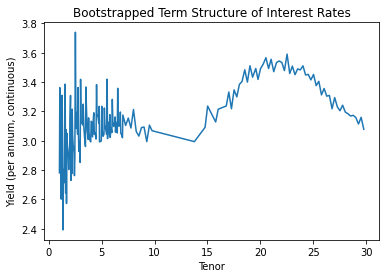

In [4]:
'''
plot bootstrapped yield curve
'''
plt.plot(rates[1:] * 100)
plt.title('Bootstrapped Term Structure of Interest Rates')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')

## Ho-Lee Model Analysis

**Definition**: Ho-Lee Model, an affine model of the form
$$dr_t = \theta(t)dt + \sigma dW_t$$

Therefore, we move to approximate $\Theta(t) = \int\theta(s)ds$ by solving
$$r_t = r_0 + \int_0^t\theta(s)ds + \sigma W_t$$
where the integral of $\theta(t)$ represents a rates forecast.

Regarding data, we assume the short rate $r_0$ to be the current Fed-Funds Rate (target of 100 basis points) and the volatility $\sigma$ to be the current ICE BofA MOVE Index, a market index that tracks implied rates volatility (the rates equivalent of the VIX index).

In [5]:
'''
Simulate 10K brownian motions of length 30 years
'''
M = 10000                                                       # 10K brownian motions -- TRIAL COUNT FOR ENTIRE FILE
n = 30 * 100                                                    # 30 years by 100 time steps per year
w_t = []
for i in range(M):
    w_t.append(np.cumsum(np.random.randn(n)*np.sqrt(0.01)))
t_i = np.array([i/100 for i in range(n)])

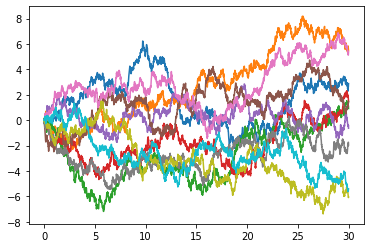

In [6]:
'''
Plot Brownian motions to confirm
'''
plt.plot(t_i,w_t[0])
plt.plot(t_i,w_t[1])
plt.plot(t_i,w_t[2])
plt.plot(t_i,w_t[3])
plt.plot(t_i,w_t[4])
plt.plot(t_i,w_t[5])
plt.plot(t_i,w_t[6])
plt.plot(t_i,w_t[7])
plt.plot(t_i,w_t[8])
plt.plot(t_i,w_t[9])

In [7]:
'''
Parameter Estimations - MARKET DATA
---
r_0 - instantaneous short rate (fed funds tager)
move - ICE BofA Rates Vol Index (ticker: MOVE)
'''
r_0 = 0.01              # fed funds target
move = 121.99 / 100     # MOVE index

In [8]:
'''
Numerically approximate Theta
---
Estimates the function $\Theta(t) = \int\theta(s)ds$
NOTE: Takes approximately 15 minutes
'''
Theta = []
for i in range(M):
        Theta.append([(rates.loc[t] - r_0 + move*w_t[i][int(t*100)])[0] for t in rates.index])
theta_est = pd.DataFrame(data=Theta,columns=rates.index).mean()

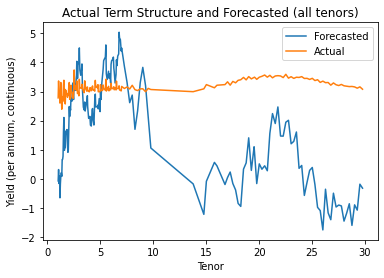

In [9]:
'''
Plotted Theta and actual term structure - all tenors
'''
plt.plot(r_0*100 + theta_est[1:]*100)
plt.plot(rates[1:]*100)
plt.title('Actual Term Structure and Forecasted (all tenors)')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')
plt.legend(['Forecasted','Actual'])

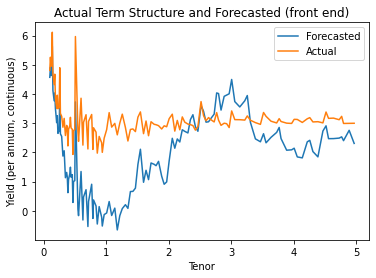

In [10]:
'''
Plotted Theta and actual term structure - Short Tenors
'''
plt.plot(r_0*100 + theta_est[0.1:5]*100)
plt.plot(rates[0.1:5]*100)
plt.title('Actual Term Structure and Forecasted (front end)')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')
plt.legend(['Forecasted','Actual'])

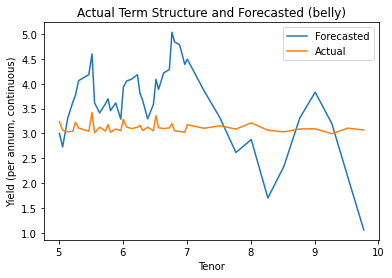

In [11]:
'''
Plotted Theta and actual term structure - intermediate Tenors
'''
plt.plot(r_0*100 + theta_est[5:10]*100)
plt.plot(rates[5:10]*100)
plt.title('Actual Term Structure and Forecasted (belly)')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')
plt.legend(['Forecasted','Actual'])

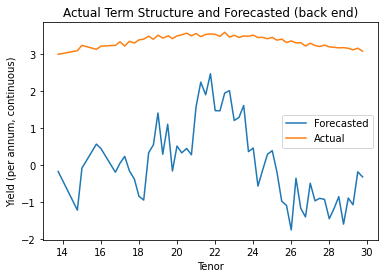

In [12]:
'''
Plotted Theta and actual term structure - long Tenors
'''
plt.plot(r_0*100 + theta_est[10:30]*100)
plt.plot(rates[10:30]*100)
plt.title('Actual Term Structure and Forecasted (back end)')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')
plt.legend(['Forecasted','Actual'])

In [13]:
'''
implied yield curves from forecast
    * 2s10s
    * 10s30s
'''
hl_yc_2s10s = theta_est[:10].iloc[-1] - theta_est[:2].iloc[-1]
hl_yc_10s30s = theta_est[:30].iloc[-1] - theta_est[:10].iloc[-1]
print('2s10s implied yield curve: {:.2f}bps'.format(hl_yc_2s10s*100))
print('10s30s implied yield curve: {:.2f}bps'.format(hl_yc_10s30s*100))

2s10s implied yield curve: 0.07bps
10s30s implied yield curve: -1.38bps


## CIR Model Analysis

**Definition**: CIR Model, an affine model of the form
$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t}dW_t$$

This is not explicitly solved and requires parameter estimation.  From there, I imply the model using monte-carlo methods and compare this implied model with the actual and previously developed rates forecast

I initially estimate $a$ and $b$ using regression, since
$$\mathbb{E}[dr_t] = \mathbb{E}[a(b-r_t)dt + \sigma\sqrt{r_t}dW_t] = a(b-r_t)dt + \sigma\sqrt{r_t}\mathbb{E}[dW_t]=ab-ar_t$$
$$\implies \Delta r_t \approx ab - a r_t = mx + c;\;\;\;a=-m,\;b = -\frac{c}{m}$$

In [14]:
'''
approximate a and b parameters
'''
rt = rates.to_numpy().squeeze()
drt = rates.diff().to_numpy().squeeze()
m,c = np.polyfit(drt[1:], rt[1:], deg=1)
b = c / (-m)
a = -m

In [15]:
'''
Approximate term structure using fitted parameters
---
NOTE: Takes approximately 15 minutes
'''
guesses = []
for i in range(M):
    guess = []
    for t in range(len(rates.index)-1):
        tk0 = rates.index[t]
        tk1 = rates.index[t+1]
        rtk = rates.loc[tk0]
        zk = np.random.normal(0,1)
        rtguess = rtk * (1 + np.sqrt(tk1-tk0)*zk + 0.5*(zk**2)*(tk1-tk0))
        guess.append(rtguess[0])
    guesses.append(guess)

In [16]:
'''
Merge approximated term structure with current term structure, filter out absurdly high rates
'''
fore_df = pd.DataFrame(pd.DataFrame(guesses,columns=rates.index[1:]).mean().transpose(),columns=['forecast'])
comps = pd.merge(
    left = fore_df,
    right = rates,
    how = 'inner',
    left_index=True,
    right_index=True
)
comps = comps[comps['forecast'] <= 0.1]

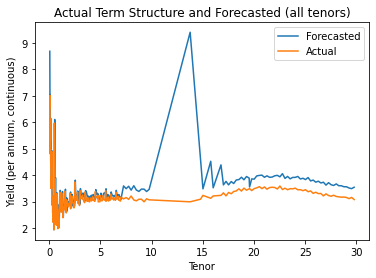

In [17]:
'''
Plot forecasted and actual term structures
'''
plt.plot(comps*100)
plt.title('Actual Term Structure and Forecasted (all tenors)')
plt.xlabel('Tenor')
plt.ylabel('Yield (per annum, continuous)')
plt.legend(['Forecasted','Actual'])

In [18]:
'''
report derived yield curves
'''
cir_yc_2s10s = fore_df.loc[:10].iloc[-1][0] - fore_df.loc[:2].iloc[-1][0]
cir_yc_10s30s = fore_df.loc[:30].iloc[-1][0] - fore_df.loc[:10].iloc[-1][0]
print('2s10s implied yield curve: {:.2f}bps'.format(cir_yc_2s10s*100))
print('10s30s implied yield curve: {:.2f}bps'.format(cir_yc_10s30s*100))

2s10s implied yield curve: 0.48bps
10s30s implied yield curve: 0.08bps
